In [1]:
import ingestor, modeller, fitter
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-notebook')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['figure.figsize'] = [15, 10]

In [3]:
from importlib import reload

reload(fitter)
reload(modeller)
reload(ingestor)

<module 'ingestor' from '/media/dwu402/Data/wrap-mad/ingestor.py'>

In [4]:
context = ingestor.initialise_context()
ingestor.read_run_file(context, "runs/royal_immune_11.run")

In [5]:
model = modeller.Model(context)

In [6]:
solver = fitter.Fitter()
solver.construct_objectives(context, model)

In [7]:
solver.construct_problems()

In [8]:
for rhoi in np.logspace(-8, 6, num=101):
    solver.solve(rhoi)
    solver.problems[0].initial_guess = solver.solutions[str(rhoi)][-1].x

In [9]:
solver.solutions

{'1e-06': [      fun: 2056521659.8005245
   hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
        jac: array([ 5.19903752e-04, -7.30673404e-04, -3.06453128e-12,  4.46250481e-19,
          1.98781373e-08,  5.68959046e-07,  8.94592789e-08,  5.68677431e-04,
         -4.03570569e-04,  5.06486926e-01,  3.85964866e-06])
    message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
       nfev: 2
        nit: 1
     status: 0
    success: True
          x: array([5.19096986e-01, 8.74602586e-01, 7.00000000e-01, 1.00000000e+00,
         2.00000000e+00, 9.99999871e-01, 9.99999937e-01, 1.12539720e+00,
         7.80902892e-01, 6.58993640e-02, 9.64701564e-04])],
 '1.3182567385564074e-06': [      fun: 2056521743.367476
   hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
        jac: array([ 1.05710973e-06,  1.80610096e-06, -5.29741238e-12,  7.68399405e-19,
          3.46740327e-08,  9.94706999e-07,  1.55084832e-07, -1.66468377e-08,
          5.55244424e-09,  2.37724027e-05,  1.0

Text(0.5, 1.0, 'Outer Objective Function Values by Algor Parameter')

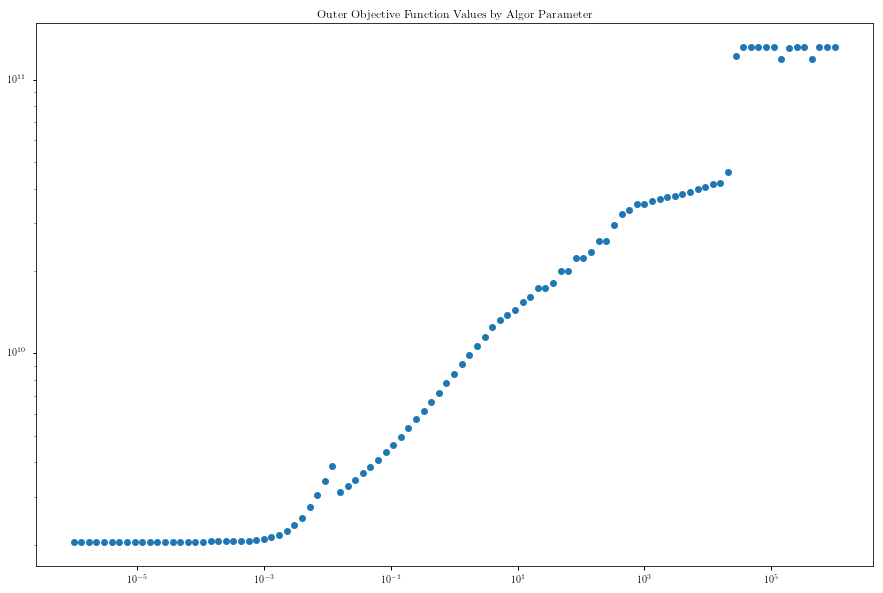

In [10]:
outer_objective_values = np.array([[float(rho), val[0].fun] for rho, val in solver.solutions.items()])
plt.loglog(*outer_objective_values.T, 'o')
plt.title("Outer Objective Function Values by Algor Parameter")

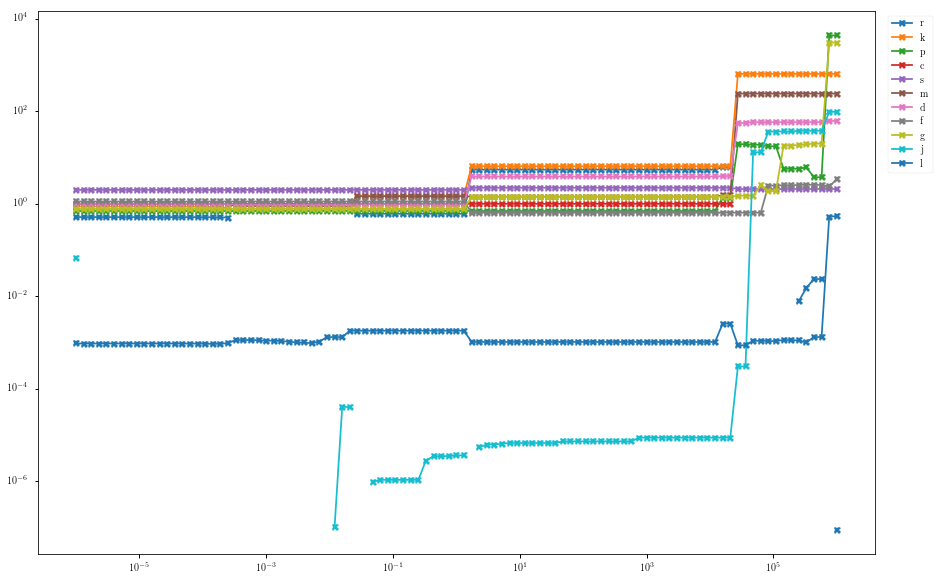

In [11]:
rhos = [float(rho) for rho in solver.solutions.keys()]
vals = [val[0].x for val in solver.solutions.values()]
plt.plot(rhos, vals, 'X-')
plt.legend("rkpcsmdfgjl", loc="best", bbox_to_anchor=(1.01, 1))
plt.xscale("log")
plt.yscale("log", nonposy="mask")

In [12]:
# generate a crude correlation plot

import pandas as pd

results = pd.DataFrame({r"$\rho$": np.log(rhos)})
for idx, name in enumerate("rkpcsmdfgjl"):
    results[name] = [v[idx] for v in vals]
    

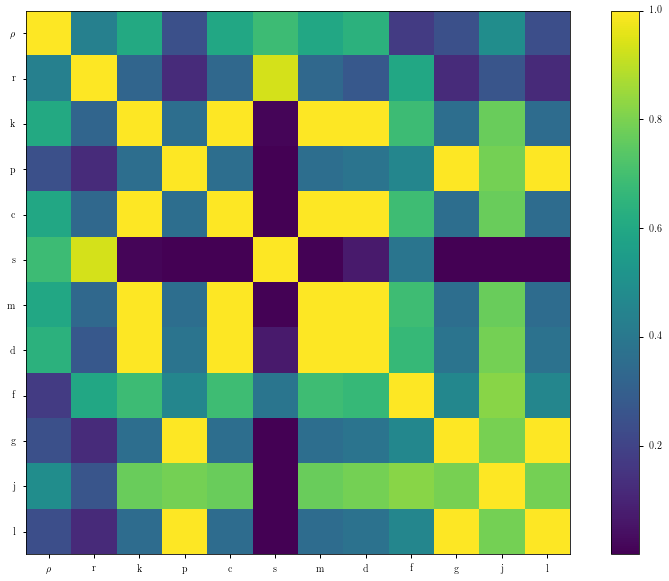

In [13]:
plt.imshow(np.abs(results.corr()))
plt.colorbar()
plt.xticks(range(12), [r"$\rho$"] + list("rkpcsmdfgjl"))
plt.yticks(range(12), [r"$\rho$"] + list("rkpcsmdfgjl"))
plt.grid(False)

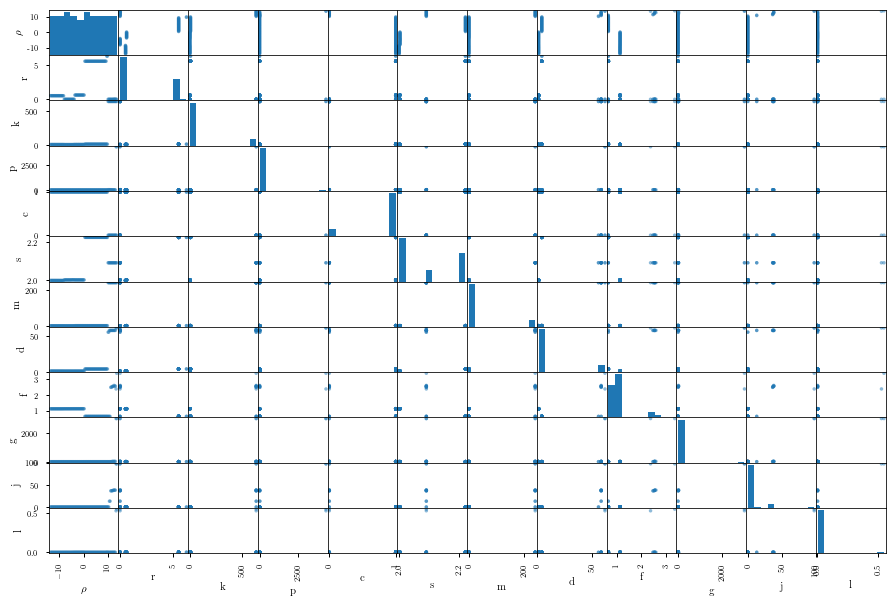

In [14]:
ax = pd.plotting.scatter_matrix(results)
for a in ax.flatten():
    a.grid(False)

Text(0, 0.5, 'Number')

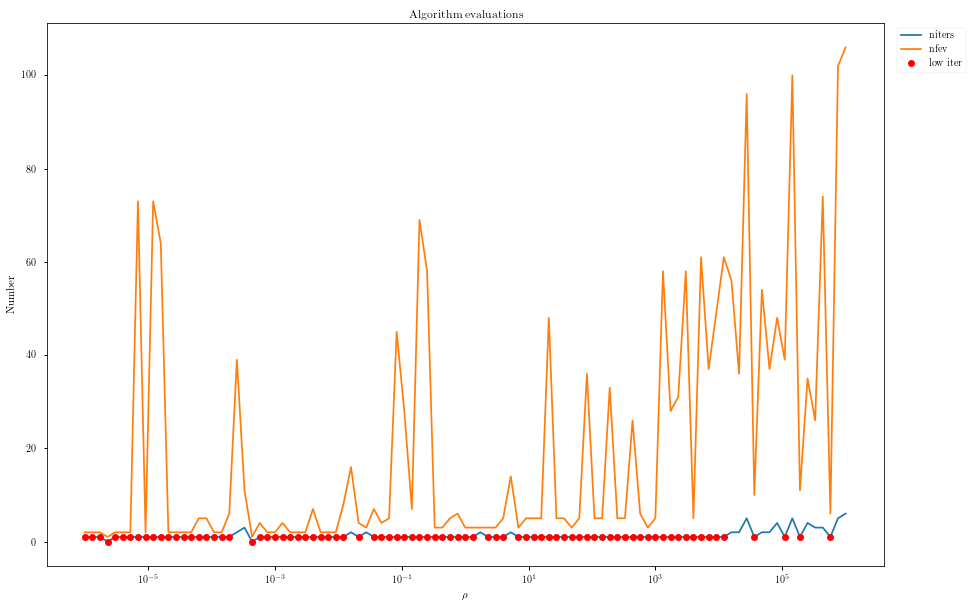

In [24]:
iters_list = np.array([[float(key), value[0].nit] for key, value in solver.solutions.items()])
fevs_list = np.array([[float(key), value[0].nfev] for key, value in solver.solutions.items()])
plt.semilogx(*iters_list.T, *fevs_list.T)

low_iters = np.array([[k,v] for k,v in iters_list if v < 2])
plt.plot(*low_iters.T, 'ro')

plt.legend(["niters", "nfev", "low iter"], 
           loc="best", bbox_to_anchor=(1.01, 1))
plt.title("Algorithm evaluations")
plt.xlabel(r"$\rho$")
plt.ylabel("Number")

In [16]:
def tokey(rho, ps):
    return f"{'y'.join(map(str,ps))}r{rho}"
getx = fitter.ca.Function("getx", [model.ts, *model.cs], model.xs)
    

Text(0.5, 0, 'time, t')

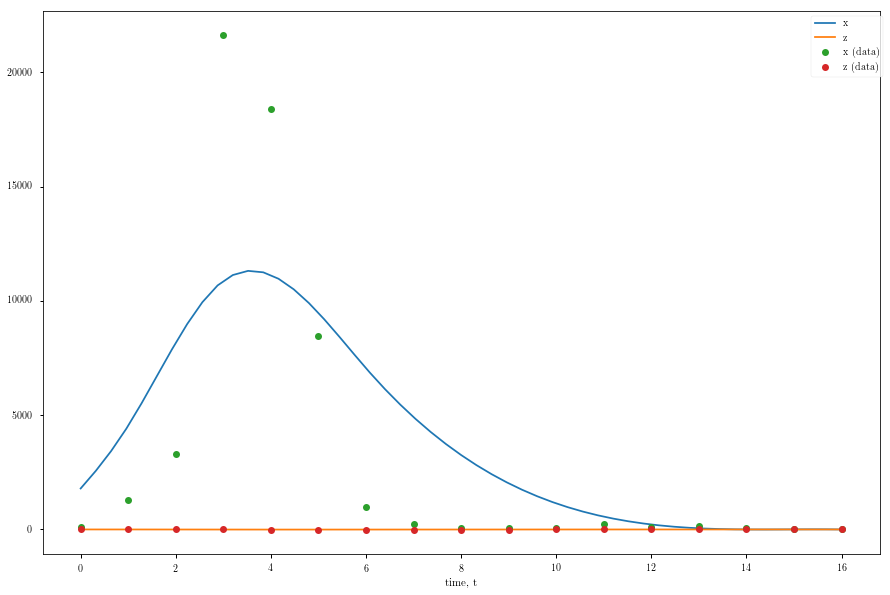

In [17]:
target_rho = 9120.108393559078
c_end = solver.problems[0].cache.results[tokey(target_rho, solver.solutions[str(target_rho)][0].x)].x

xs_end = np.array([np.array(i) for i in getx(model.observation_times, 
                                         *fitter.argsplit(c_end, 
                                                          3)
                                        )])

xscale = 50
plt.plot(model.observation_times, np.hstack([xs_end[0]/xscale, xs_end[2]]),
         context['datasets'][0]['t'], context['datasets'][0]['x']/xscale, 'o',
         context['datasets'][0]['t'], context['datasets'][0]['z'], 'o')
plt.legend(list("xz") + ["x (data)", "z (data)"], loc="best", bbox_to_anchor=(1.01, 1))
plt.xlabel("time, t")

In [18]:
inner_objective_values = np.array([[r, solver.problems[0].cache.results[tokey(r, v)].fun] for r,v in zip(rhos, vals)])
dfield = np.hstack([np.array(rhos).reshape(-1,1), 
                    ((inner_objective_values - outer_objective_values)[:,1] / rhos).reshape(-1,1)])


Text(0, 0.5, 'Diff Field')

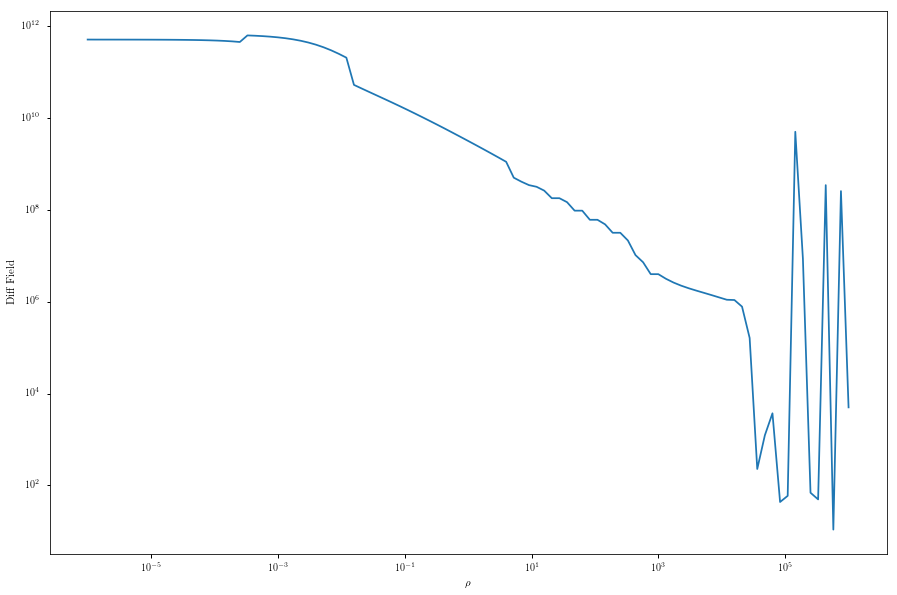

In [19]:
plt.loglog(*dfield.T)
plt.xlabel(r"$\rho$")
plt.ylabel("Diff Field")

Text(0, 0.5, 'Outer Objective (Data Fit)')

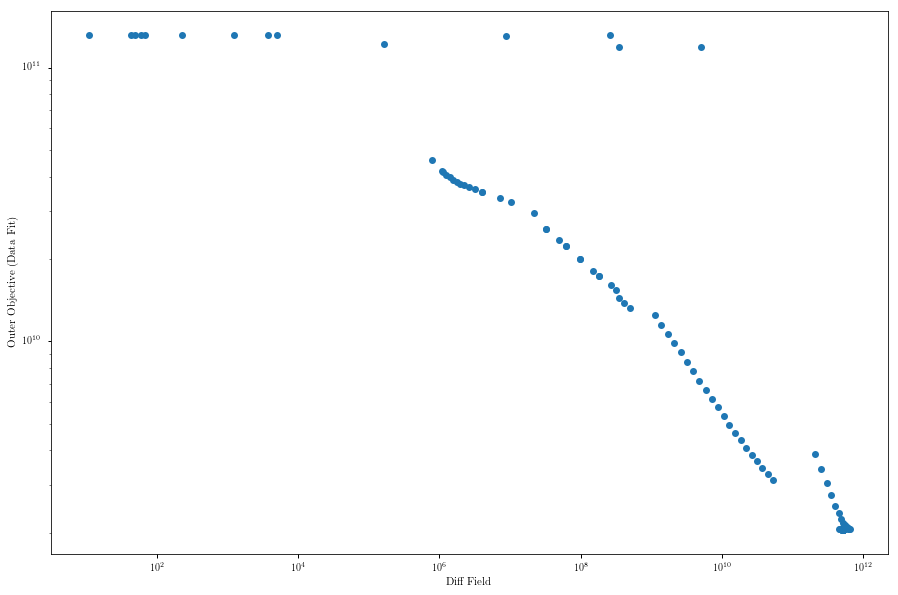

In [20]:
plt.loglog(dfield[:,1] , outer_objective_values[:,1], 'o')
plt.xlabel("Diff Field")
plt.ylabel("Outer Objective (Data Fit)")

In [21]:
solver.solutions[str(target_rho)]

[      fun: 40624154116.47443
  hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
       jac: array([-6.84895228e+03,  2.49545763e+04,  5.39951673e+02, -6.09597351e+01,
        -3.03913384e+02,  2.69054306e+02,  6.21611097e+02,  1.31268009e+02,
        -1.47426951e+02,  1.56357669e+07, -1.31833194e+01])
   message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
      nfev: 49
       nit: 1
    status: 0
   success: True
         x: array([5.48718072e+00, 6.53804757e+00, 7.01649908e-01, 1.00000665e+00,
        2.22319769e+00, 1.43243252e+00, 3.90787318e+00, 6.45368861e-01,
        1.41964590e+00, 8.86065879e-06, 1.03641059e-03])]

In [22]:
rhos

[1e-06,
 1.3182567385564074e-06,
 1.7378008287493763e-06,
 2.2908676527677747e-06,
 3.0199517204020193e-06,
 3.981071705534969e-06,
 5.248074602497723e-06,
 6.9183097091893625e-06,
 9.120108393559096e-06,
 1.2022644346174132e-05,
 1.584893192461114e-05,
 2.089296130854041e-05,
 2.7542287033381633e-05,
 3.6307805477010174e-05,
 4.7863009232263804e-05,
 6.309573444801929e-05,
 8.317637711026709e-05,
 0.00010964781961431851,
 0.0001445439770745928,
 0.00019054607179632462,
 0.00025118864315095795,
 0.0003311311214825911,
 0.0004365158322401656,
 0.0005754399373371566,
 0.0007585775750291835,
 0.001,
 0.0013182567385564075,
 0.0017378008287493745,
 0.0022908676527677724,
 0.003019951720402016,
 0.003981071705534969,
 0.005248074602497723,
 0.006918309709189363,
 0.009120108393559097,
 0.012022644346174132,
 0.01584893192461114,
 0.02089296130854041,
 0.027542287033381633,
 0.036307805477010104,
 0.0478630092322638,
 0.0630957344480193,
 0.08317637711026708,
 0.1096478196143185,
 0.14454397